In [ ]:
# !pip install --upgrade jsonpickle tweepy

In [ ]:
import os
os.chdir('drive/My Drive/twitter-bot-detection')
os.getcwd()

'/content/drive/My Drive/twitter-bot-detection'

In [ ]:
import sys
import jsonpickle
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC

from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
bot_df = pd.read_csv(r"data/final_bots.csv",index_col='User ID')
user_df = pd.read_csv(r"data/final_users.csv",index_col='User ID')

In [ ]:
bot_df['bot']=1
user_df['bot']=0
total_df = bot_df.append(user_df)

In [ ]:
train_data, test_data = train_test_split(total_df, test_size = 0.2, random_state=87)

Y_train=train_data['bot']
Y_test=test_data['bot']
X_train=train_data.drop('bot',axis=1)
X_test=test_data.drop('bot',axis=1)
X_train = X_train.drop(['Account age (days)'], axis=1)
X_test = X_test.drop(['Account age (days)'], axis=1)

In [ ]:
print(np.count_nonzero(Y_test)/len(Y_test))
print(np.count_nonzero(Y_train)/len(Y_train))

0.45491643995336184
0.45430251202565475


In [ ]:
# def normalize(df,df_train):
#     result = df.copy()
#     for feature_name in df_train.columns:
#         max_value = df_train[feature_name].max()
#         min_value = df_train[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result

# X_train_scaled=normalize(X_train,X_train)
# X_test_scaled=normalize(X_test,X_train)
# X_train_scaled.describe()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train_scaled=scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled=scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_train.columns)

In [ ]:
X_train_scaled.describe()

,Screen name length,Number of digits in screen name,User name length,Default profile (binary),Default picture (binary),Number of unique profile descriptions,Number of friends,Number of followers,Number of favorites,Number of tweets per hour,Number of tweets total,timing_tweet
count,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000,20581.000000
mean,0.680138,0.026441,0.221217,0.128711,0.026627,0.047619,0.000891,0.000184,0.004234,0.008021,0.007801,0.717822
std,0.207034,0.078484,0.104966,0.334888,0.160993,0.091744,0.008337,0.007207,0.019174,0.022343,0.022043,0.178786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.538462,0.000000,0.163265,0.000000,0.000000,0.000000,0.000059,0.000002,0.000000,0.000162,0.000152,0.588563
50%,0.692308,0.000000,0.224490,0.000000,0.000000,0.000000,0.000173,0.000007,0.000030,0.001813,0.001737,0.733345
75%,0.846154,0.000000,0.285714,0.000000,0.000000,0.055556,0.000526,0.000026,0.001232,0.007701,0.007168,0.869844
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Logistic Regression
logreg = LogisticRegression(C=100000,fit_intercept=True).fit(X_train_scaled,Y_train)
logreg_train = logreg.score(X_train_scaled, Y_train)

print('Accuracy of logistic regression model on training set is {:.3f}'.format(logreg_train))
# Classification error on test set
lr_pred = logreg.predict(X_test_scaled)
logreg_test = logreg.score(X_test_scaled, Y_test)
print('Accuracy of logistic regression model on the test set is {:.3f}'.format(logreg_test))

Accuracy of logistic regression model on training set is 0.765
Accuracy of logistic regression model on the test set is 0.751


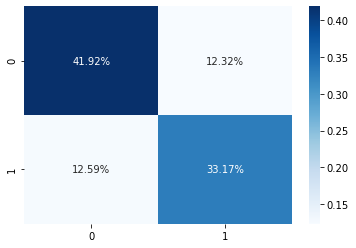

In [ ]:
cf_matrix = confusion_matrix(lr_pred,Y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
# Logistic regression w/ quadratic + interaction terms + regularization
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LogisticRegressionCV(multi_class="ovr", penalty='l2', cv=5, max_iter=10000))
linearLogCVpoly = polynomial_logreg_estimator.fit(X_train_scaled, Y_train)
# Compare results
print('Polynomial-logistic accuracy: train={:.1%}, test={:.1%}'.format(
    linearLogCVpoly.score(X_train_scaled, Y_train), linearLogCVpoly.score(X_test_scaled, Y_test)))
linearLogCVpoly_train = linearLogCVpoly.score(X_train_scaled, Y_train)
linearLogCVpoly_test = linearLogCVpoly.score(X_test_scaled, Y_test)

Polynomial-logistic accuracy: train=78.3%, test=77.0%


In [ ]:
# LDA and QDA Model
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train_scaled, Y_train)
qda.fit(X_train_scaled, Y_train)
lda.predict(X_test_scaled)
qda.predict(X_test_scaled)

print('LDA accuracy train={:.1%}, test: {:.1%}'.format(
    lda.score(X_train_scaled, Y_train), lda.score(X_test_scaled, Y_test)))

lda_train = lda.score(X_train_scaled, Y_train)
lda_test = lda.score(X_test_scaled, Y_test)

print('QDA accuracy train={:.1%}, test: {:.1%}'.format(
    qda.score(X_train_scaled, Y_train), qda.score(X_test_scaled, Y_test)))

qda_train = qda.score(X_train_scaled, Y_train)
qda_test = qda.score(X_test_scaled, Y_test)

LDA accuracy train=67.1%, test: 66.0%
QDA accuracy train=70.2%, test: 69.2%


In [ ]:
# Random Forest
ntrees = 50
rf = RandomForestClassifier(n_estimators=ntrees , max_depth=15, max_features='auto')
rf.fit(X_train_scaled, Y_train)
rf_train =rf.score(X_train_scaled, Y_train)
rf_test =rf.score(X_test_scaled, Y_test)

print('RF accuracy train={:.1%}, test: {:.1%}'.format(rf_train,rf_test))

RF accuracy train=97.8%, test: 89.3%


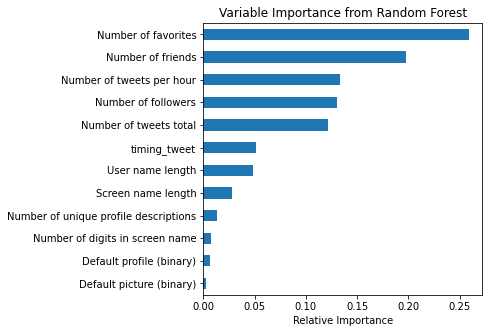

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Variable Importance from Random Forest')
plt.xlabel('Relative Importance')
pd.Series(rf.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

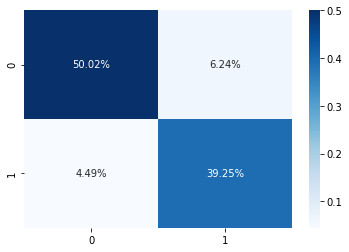

In [ ]:
rf_pred = rf.predict(X_test_scaled)
cf_matrix = confusion_matrix(rf_pred,Y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
# svm
def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)
    return tr_acc, ts_acc

In [ ]:
# Fit and plot for different 'C' values
tr_acc, ts_acc = fit_and_plot_svm_for_c(X_train_scaled, Y_train,X_test_scaled, Y_test, 0.1)

In [ ]:
print(tr_acc, ts_acc)

0.6387444730576746 0.6319471434123591


In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores_mean=[]
scores_std=[]

k_number=np.arange(1,40)

for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = k)
    score_mean= cross_val_score(knn,X_train_scaled,Y_train,cv=5).mean()
    score_std=cross_val_score(knn,X_train_scaled,Y_train,cv=5).std()
    scores_mean.append(score_mean)

In [ ]:
max_score_k=max(scores_mean)
best_k=scores_mean.index(max(scores_mean))+1
print('Best K=',best_k, 'with a max CV score of',max_score_k)

knn_best_k = KNeighborsClassifier(n_neighbors = best_k)
knn_best_k.fit(X_train_scaled,Y_train);

pred_best_k = knn_best_k.predict(X_test_scaled)

print('test accuracy',accuracy_score(Y_test, pred_best_k))

knn_best_k_train = knn_best_k.score(X_train_scaled, Y_train)
knn_best_k_test = knn_best_k.score(X_test_scaled, Y_test)

Best K= 34 with a max CV score of 0.6800929469952387
test accuracy 0.6706179556937427


In [ ]:
# adaBoost
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=800, learning_rate=0.01)
adaboost.fit(X_train_scaled, Y_train);

In [ ]:
y_pred_test = adaboost.predict(X_test_scaled)
pred_adaboost = [round(value) for value in y_pred_test]
adaboost_accuracy = accuracy_score(Y_test, pred_adaboost)
print('test acc:',adaboost_accuracy)

test acc: 0.8907889623008162


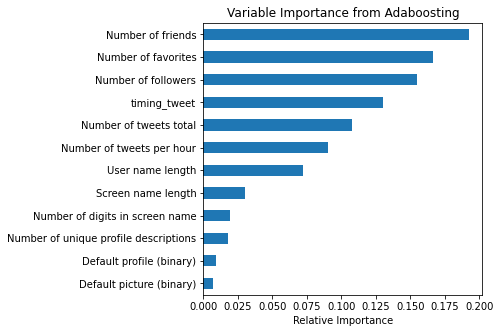

In [ ]:

plt.figure(figsize=(5,5))
plt.title('Variable Importance from Adaboosting')
plt.xlabel('Relative Importance')
pd.Series(adaboost.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

In [ ]:

import xgboost as xgb
from sklearn.metrics import confusion_matrix


xgb = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01).fit(X_train_scaled, Y_train)
y_pred_test_xgb = xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(Y_test, y_pred_test_xgb)


print("test Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

test Accuracy: 89.35%


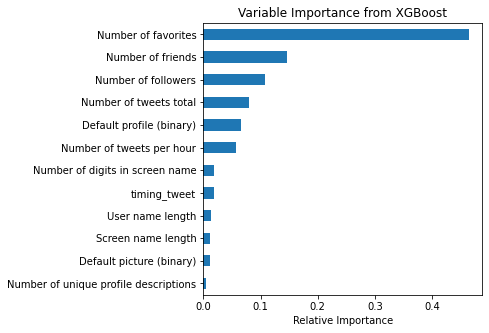

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Variable Importance from XGBoost')
plt.xlabel('Relative Importance')
pd.Series(xgb.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

#Model Comparison

In [ ]:
dict_var = {
            "test accuracy": [logreg_test, linearLogCVpoly_test, rf_test, knn_best_k_test ,lda_test,qda_test, adaboost_accuracy, accuracy_xgb],
            "training accuracy": [logreg_train, linearLogCVpoly_train, rf_train, knn_best_k_train ,lda_train,qda_train, adaboost_accuracy, accuracy_xgb],
           }
print("Performance comparison of the six methods:")
df_var = pd.DataFrame.from_dict(dict_var)
df_var.index= ['Linear LR', 'Polynomial LR', 'Random Forest', 'kNN', 'LDA', 'QDA', 'AdaBoost', 'XGBoost']
display(df_var)

Performance comparison of the six methods:


,test accuracy,training accuracy
Linear LR,0.750874,0.764734
Polynomial LR,0.770113,0.782566
Random Forest,0.892732,0.976775
kNN,0.670618,0.705748
LDA,0.659930,0.671202
QDA,0.691994,0.702104
AdaBoost,0.890789,0.890789
XGBoost,0.893510,0.893510


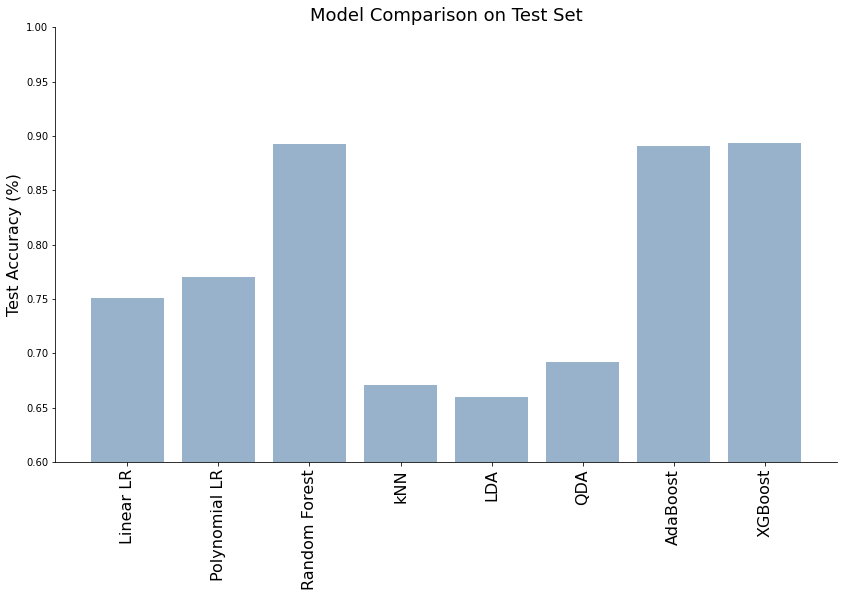

In [ ]:
plt.figure(figsize=(14,8))
xx = range(len(df_var))
index_name=df_var.index
plt.bar(xx, df_var['test accuracy'], color=(0.2, 0.4, 0.6, 0.6), alpha=0.5)
plt.ylim(0.6,1)
plt.title('Model Comparison on Test Set', fontsize=18)
plt.ylabel('Test Accuracy (%)', fontsize=16)
plt.xticks(xx,index_name,rotation=90,fontsize = 16);
sns.despine()

In [ ]:
#  export models to files
import pickle
models = [xgb,adaboost,rf,scaler]
model_names = ['xgb','adaboost','rf','scaler']
for i in range(len(models)):
    pickle.dump(models[i], open('models/'+model_names[i], 'wb'))
 
 

In [ ]:
# import pickle
# model_names = ['xgb','adaboost','rf','scaler']
# for i in range(4):
#     pickle.load(open('models/'+model_names[i], 'rb'))

#Neural Network

In [ ]:

import tensorflow.keras 
from tensorflow.keras import models
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from sklearn.metrics import r2_score as r2

from sklearn.utils import shuffle
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# import tensorflow.contrib.eager as tfe
# from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [ ]:
model_NN = models.Sequential()

model_NN.add(layers.Dense(400, input_shape=(X_train_scaled.shape[1],),
                activation='relu'))

model_NN.add(layers.Dense(100, input_shape=(X_train_scaled.shape[1],),
                activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model_NN.add(Dropout(0.5))
          


model_NN.add(layers.Dense(1,  
                activation='sigmoid')) 

model_NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 400)               5200      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               40100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 45,401
Trainable params: 45,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tensorflow.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_NN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
%%capture
ANN_history = model_NN.fit(X_train_scaled, Y_train,batch_size=128,epochs=300,validation_split=0.2)

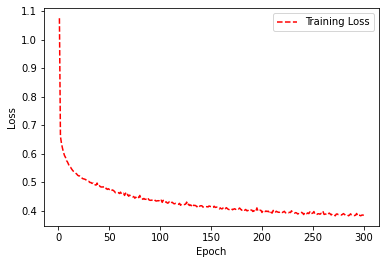

In [ ]:
training_loss = ANN_history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
ANN_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

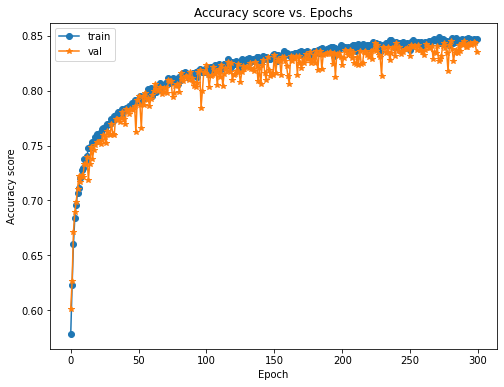

In [ ]:

fig, axs = plt.subplots(figsize=(8, 6))
plt.plot(ANN_history.history['accuracy'], '-o', label='train')
plt.plot(ANN_history.history['val_accuracy'], '-*', label='val')

plt.ylabel("Accuracy score")
plt.xlabel("Epoch")
plt.title("Accuracy score vs. Epochs")

plt.legend()
plt.show()

In [ ]:
test_loss,test_acc = model_NN.evaluate(X_test_scaled, Y_test, verbose=1)
print('Test loss:', test_loss)
print('Test ACC:', test_acc)

161/161 [==============================] - 0s 980us/step - loss: 0.3939 - accuracy: 0.8340
Test loss: 0.3938627243041992
Test ACC: 0.8340458869934082
